# 02. Advanced SwinIR Training (PRO DEBUGGER MODE)

**Objective**: Scientifically evaluate and debug SwinIR training for Gravitational Lensing.

### 🛡️ Pro Debugger Features
1. **Scientific Metrics**: PSNR, SSIM, MSE, MAE (L1).
2. **Stability Safeguards**: Gradient Clipping, Data Range Checks, Weight Initialization.
3. **Transparent Logging**: Train vs. Val Loss comparison, Gradient Norm tracking.
4. **Memory Management**: Automatic cache management for NVIDIA GPUs.

In [1]:
import torch
import sys
import os
import gc

# Add parent directory to path to import local modules
sys.path.append(os.path.abspath('..'))

from model import SwinIR
from dataset import LensingDataset

print(f'Python Executable: {sys.executable}')
print(f'PyTorch Version: {torch.__version__}')
print(f'CUDA Available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU Device: {torch.cuda.get_device_name(0)}')
    torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Training on: {DEVICE}')

Python Executable: d:\ML4SCI\DeepLense\.venv\Scripts\python.exe
PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU
Training on: cuda


### 1. Advanced Configuration

In [ ]:
 import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.models as models
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import wandb
import os  # Ensure os is imported for path operations

# --- CONFIGURATION ---
PRESET = "STANDARD"  # "TURBO", "STANDARD", "RESEARCH"
LEARNING_RATE = 2e-4
GRAD_CLIP = 5.0      # PREVENT EXPLODING GRADIENTS
DATA_DIR = os.path.abspath('../data_diff')
WANDB_MODE = "disabled"

if PRESET == "TURBO":
    EMBED_DIM, DEPTHS, HEADS, EPOCHS, BATCH_SIZE, USE_PERCEP = 30, [2,2,2,2], [2,2,2,2], 5, 32, False
elif PRESET == "STANDARD":
    EMBED_DIM, DEPTHS, HEADS, EPOCHS, BATCH_SIZE, USE_PERCEP = 60, [4,4,4,4], [4,4,4,4], 20, 16, True
elif PRESET == "RESEARCH":
    EMBED_DIM, DEPTHS, HEADS, EPOCHS, BATCH_SIZE, USE_PERCEP = 60, [6,6,6,6], [6,6,6,6], 50, 8, True

print(f'[PRO DEBUGGER] Active Preset: {PRESET} | Grad Clip: {GRAD_CLIP}')
print(f'Data Directory: {DATA_DIR}')

d:\ML4SCI\DeepLense\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[PRO DEBUGGER] Active Preset: STANDARD | Grad Clip: 5.0
Data Directory: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\data_diff


### 2. Robust Dataset & Sanity Checks

In [3]:
def sanity_check_data():
    hr_path = os.path.join(DATA_DIR, 'train_HR.npy')
    lr_path = os.path.join(DATA_DIR, 'train_LR.npy')
    if not os.path.exists(hr_path):
        print(f'⚠️ ERROR: {hr_path} not found!')
        return
    
    test_ds = LensingDataset(hr_path, lr_path)
    if len(test_ds) == 0:
        print('⚠️ ERROR: Dataset is empty!')
        return
        
    lr, hr = test_ds[0]
    print(f'Data Shape: LR {lr.shape}, HR {hr.shape}')
    print(f'Value Range: [{lr.min():.2f}, {lr.max():.2f}] (Expected ~[-1, 1])')
    if abs(lr.min()) > 2 or abs(lr.max()) > 2:
        print('🚨 WARNING: High values detected. Normalization might be broken!')

sanity_check_data()

Loaded 2250 samples.
Data Shape: LR torch.Size([1, 64, 64]), HR torch.Size([1, 128, 128])
Value Range: [-1.00, 1.00] (Expected ~[-1, 1])


### 3. SwinIR with Pro Weight Initialization

In [4]:
# Model is imported from model.py in the first cell
print('SwinIR model initialized from model.py')
test_model = SwinIR(embed_dim=EMBED_DIM, depths=DEPTHS, num_heads=HEADS)
print(f'Model Parameter Count: {sum(p.numel() for p in test_model.parameters()):,}')

SwinIR model initialized from model.py
Model Parameter Count: 1,011,481


### 4. Loss & Scientific Judge Class

In [5]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            vgg = models.vgg19(weights='DEFAULT').features[:35].eval().to(DEVICE)
        except: 
            print("⚠️ Failed to load VGG weights. Training without Perceptual Loss.")
            self.vgg = None
            return
        for param in vgg.parameters(): param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.L1Loss()

    def forward(self, sr, hr):
        if self.vgg is None: return torch.tensor(0.0).to(DEVICE)
        if sr.shape[1] == 1: sr, hr = sr.repeat(1,3,1,1), hr.repeat(1,3,1,1)
        return self.criterion(self.vgg((sr+1)/2), self.vgg((hr+1)/2))

class ScientificJudge:
    @staticmethod
    def compute_all(hr, sr):
        """Expects numpy arrays (H, W)"""
        results = {
            "PSNR": psnr(hr, sr, data_range=2.0),
            "SSIM": ssim(hr, sr, data_range=2.0),
            "MSE": np.mean((hr - sr)**2),
            "MAE": np.mean(np.abs(hr - sr))
        }
        return results

### 5. Pro Debugger Training Loop

Loaded 2250 samples.
Loaded 250 samples.


Epoch 1/20: 100%|██████████| 141/141 [00:55<00:00,  2.54it/s, L=0.6380]


Epoch 1 | Avg Loss: 1.7643 | Val PSNR: 13.95dB


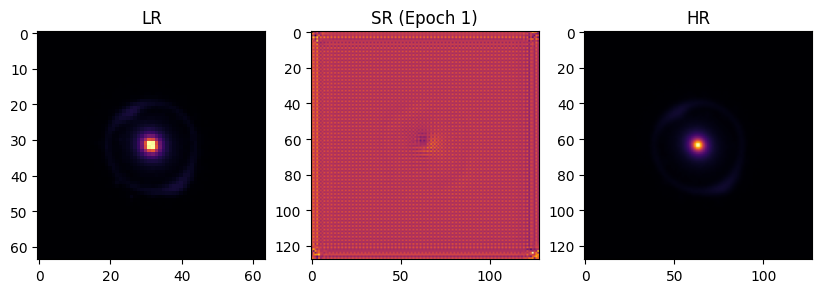

Epoch 2/20: 100%|██████████| 141/141 [00:51<00:00,  2.72it/s, L=0.2699]


Epoch 2 | Avg Loss: 0.3074 | Val PSNR: 18.16dB


Epoch 3/20: 100%|██████████| 141/141 [00:51<00:00,  2.73it/s, L=0.2372]


Epoch 3 | Avg Loss: 0.2696 | Val PSNR: 21.43dB


Epoch 4/20: 100%|██████████| 141/141 [00:51<00:00,  2.76it/s, L=0.2442]


Epoch 4 | Avg Loss: 0.2318 | Val PSNR: 19.15dB


Epoch 5/20: 100%|██████████| 141/141 [00:51<00:00,  2.76it/s, L=0.2060]


Checkpoint saved: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_5.pth
Epoch 5 | Avg Loss: 0.1969 | Val PSNR: 22.67dB


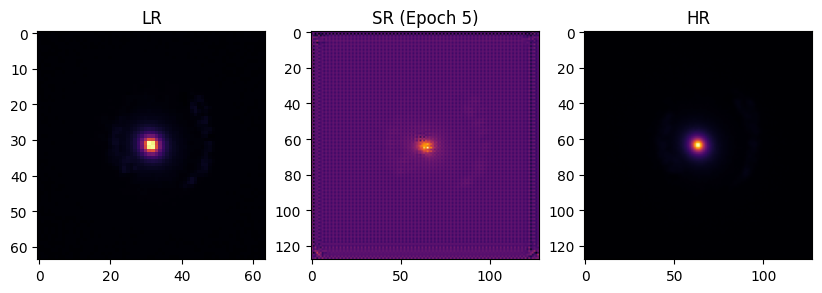

Epoch 6/20: 100%|██████████| 141/141 [00:51<00:00,  2.72it/s, L=0.1935]


Epoch 6 | Avg Loss: 0.1677 | Val PSNR: 23.52dB


Epoch 7/20: 100%|██████████| 141/141 [00:51<00:00,  2.75it/s, L=0.1202]


Epoch 7 | Avg Loss: 0.1601 | Val PSNR: 25.60dB


Epoch 8/20: 100%|██████████| 141/141 [00:52<00:00,  2.68it/s, L=0.1001]


Epoch 8 | Avg Loss: 0.1153 | Val PSNR: 28.38dB


Epoch 9/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.1095]


Epoch 9 | Avg Loss: 0.1283 | Val PSNR: 28.79dB


Epoch 10/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.1103]


Checkpoint saved: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_10.pth
Epoch 10 | Avg Loss: 0.1230 | Val PSNR: 27.10dB


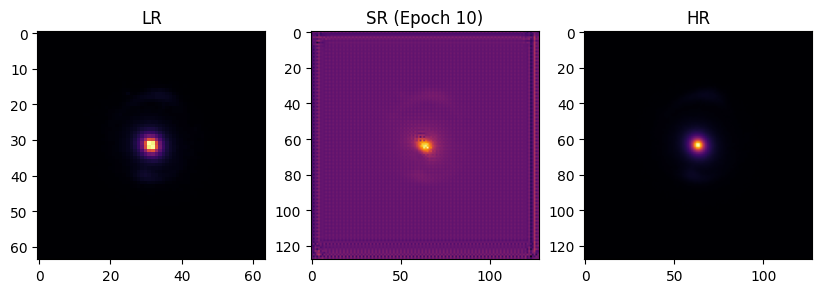

Epoch 11/20: 100%|██████████| 141/141 [00:51<00:00,  2.72it/s, L=0.0723]


Epoch 11 | Avg Loss: 0.0962 | Val PSNR: 32.36dB


Epoch 12/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.0538]


Epoch 12 | Avg Loss: 0.0707 | Val PSNR: 34.09dB


Epoch 13/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.0386]


Epoch 13 | Avg Loss: 0.0513 | Val PSNR: 34.87dB


Epoch 14/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.0341]


Epoch 14 | Avg Loss: 0.0450 | Val PSNR: 36.91dB


Epoch 15/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.0328]


Checkpoint saved: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_15.pth
Epoch 15 | Avg Loss: 0.0391 | Val PSNR: 37.49dB


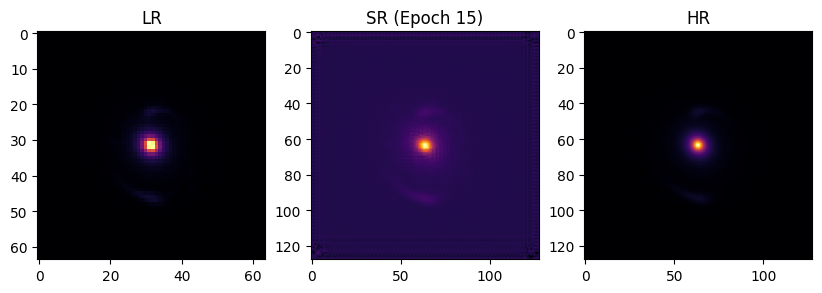

Epoch 16/20: 100%|██████████| 141/141 [00:51<00:00,  2.74it/s, L=0.0226]


Epoch 16 | Avg Loss: 0.0305 | Val PSNR: 40.95dB


Epoch 17/20: 100%|██████████| 141/141 [00:52<00:00,  2.69it/s, L=0.0145]


Epoch 17 | Avg Loss: 0.0165 | Val PSNR: 42.65dB


Epoch 18/20: 100%|██████████| 141/141 [00:52<00:00,  2.69it/s, L=0.0149]


Epoch 18 | Avg Loss: 0.0146 | Val PSNR: 43.17dB


Epoch 19/20: 100%|██████████| 141/141 [00:51<00:00,  2.73it/s, L=0.0123]


Epoch 19 | Avg Loss: 0.0133 | Val PSNR: 43.23dB


Epoch 20/20: 100%|██████████| 141/141 [00:51<00:00,  2.73it/s, L=0.0114]


Checkpoint saved: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_20.pth
Epoch 20 | Avg Loss: 0.0125 | Val PSNR: 43.75dB


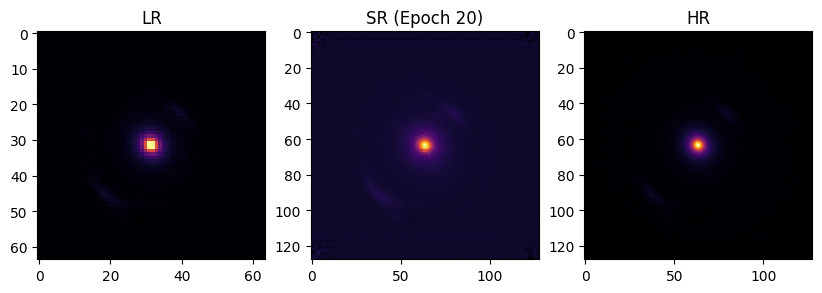

Final model saved to d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_final.pth


In [6]:
def train_pro():
    hr_path = os.path.join(DATA_DIR, 'train_HR.npy')
    lr_path = os.path.join(DATA_DIR, 'train_LR.npy')
    
    if not os.path.exists(hr_path):
        print(f'🚨 DATA NOT FOUND: Run 01_Advanced_Data_Simulation.ipynb first!')
        return

    wandb.init(project="SwinIR_Lensing_Pro", mode=WANDB_MODE)
    
    # Data
    train_loader = DataLoader(LensingDataset(hr_path, lr_path), 
                              batch_size=BATCH_SIZE, shuffle=True, pin_memory=(DEVICE == 'cuda'))
    
    val_hr_path = os.path.join(DATA_DIR, 'test_HR.npy')
    val_lr_path = os.path.join(DATA_DIR, 'test_LR.npy')
    val_ds = LensingDataset(val_hr_path, val_lr_path)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    
    model = SwinIR(embed_dim=EMBED_DIM, depths=DEPTHS, num_heads=HEADS).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion_pixel = nn.L1Loss()
    criterion_percep = PerceptualLoss() if USE_PERCEP else None
    
    scaler = torch.amp.GradScaler('cuda') if DEVICE == 'cuda' else None
    history = {'train_loss': [], 'val_psnr': []}
    
    output_model_path = os.path.abspath('../swinir_advanced_epoch_final.pth')
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
        
        for lr, hr in pbar:
            lr, hr = lr.to(DEVICE), hr.to(DEVICE)
            optimizer.zero_grad()
            
            with torch.amp.autocast(device_type=DEVICE, enabled=(DEVICE == 'cuda')):
                sr = model(lr)
                loss = criterion_pixel(sr, hr)
                if criterion_percep: loss += 0.1 * criterion_percep(sr, hr)
            
            if not torch.isfinite(loss): 
                print(f'🚨 CRITICAL BUG: LOSS IS {loss.item()}! Skipping batch.')
                continue
                
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
                optimizer.step()
                
            epoch_loss += loss.item()
            pbar.set_postfix({'L': f'{loss.item():.4f}'})
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.abspath(f'../swinir_advanced_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')
        
        # Validation & Metrics
        model.eval()
        v_psnr = 0
        num_val = min(10, len(val_ds))
        if num_val > 0:
            with torch.no_grad():
                for i in range(num_val):
                    l_v, h_v = val_ds[i]
                    s_v = model(l_v.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
                    v_psnr += ScientificJudge.compute_all(h_v.squeeze().numpy(), s_v)['PSNR']
            avg_psnr = v_psnr / num_val
        else:
            avg_psnr = 0
            
        print(f'Epoch {epoch+1} | Avg Loss: {epoch_loss/len(train_loader):.4f} | Val PSNR: {avg_psnr:.2f}dB')
        history['train_loss'].append(epoch_loss/len(train_loader))
        history['val_psnr'].append(avg_psnr)
        scheduler.step()
        
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()
        
        # Periodic visualization during training
        if (epoch + 1) % 5 == 0 or epoch == 0:
             idx = np.random.randint(0, len(val_ds))
             l_v, h_v = val_ds[idx]
             with torch.no_grad():
                 s_v = model(l_v.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
             plt.figure(figsize=(10, 3))
             plt.subplot(1, 3, 1); plt.imshow(l_v.squeeze(), cmap='inferno'); plt.title('LR')
             plt.subplot(1, 3, 2); plt.imshow(s_v, cmap='inferno'); plt.title(f'SR (Epoch {epoch+1})')
             plt.subplot(1, 3, 3); plt.imshow(h_v.squeeze(), cmap='inferno'); plt.title('HR')
             plt.show()

    torch.save(model.state_dict(), output_model_path)
    print(f'Final model saved to {output_model_path}')
    return history

history = train_pro()

### 6. Full Scientific Evaluation

Loading model from: d:\ML4SCI\DeepLense\Super_Resolution_SwinIR_Sarvesh_Rathod\swinir_advanced_epoch_final.pth
Loaded 250 samples.
Evaluating on test set...


C:\Users\SARVESH  RATHOD\AppData\Local\Temp\ipykernel_28600\2144354391.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_


--- SCIENTIFIC REPORT ---
PSNR: 44.1272
SSIM: 0.9868
MSE : 0.0002
MAE : 0.0060


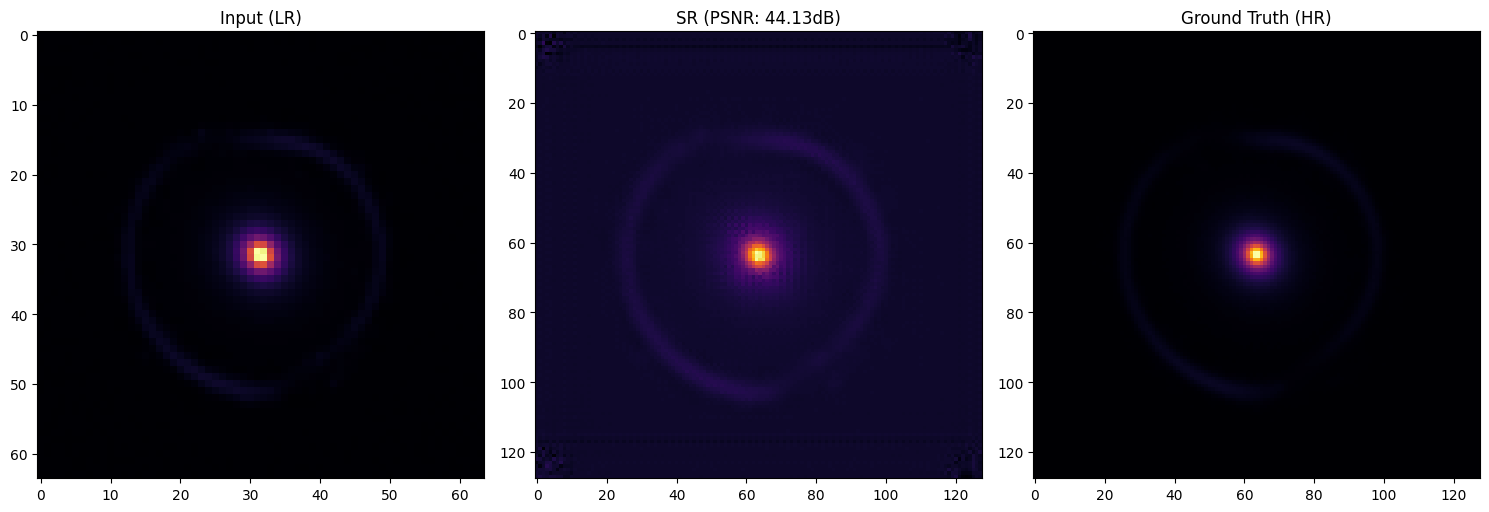

In [7]:
def run_scientific_evaluation():
    # Try to find the most recent checkpoint
    model_paths = [
        os.path.abspath('../swinir_advanced_epoch_final.pth'),
        os.path.abspath('../swinir_advanced_epoch_20.pth'),
        os.path.abspath('../swinir_advanced_epoch_15.pth'),
        os.path.abspath('../swinir_advanced_epoch_10.pth'),
        os.path.abspath('../swinir_advanced_epoch_5.pth'),
    ]
    
    model_path = None
    for path in model_paths:
        if os.path.exists(path):
            model_path = path
            break
    
    if model_path is None:
        print(f'⚠️ ERROR: No model file found! Please train the model first.')
        return
        
    print(f'Loading model from: {model_path}')
    model = SwinIR(embed_dim=EMBED_DIM, depths=DEPTHS, num_heads=HEADS).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    
    test_hr_path = os.path.join(DATA_DIR, 'test_HR.npy')
    test_lr_path = os.path.join(DATA_DIR, 'test_LR.npy')
    test_ds = LensingDataset(test_hr_path, test_lr_path)
    all_metrics = []
    
    print('Evaluating on test set...')
    eval_count = min(30, len(test_ds))
    for i in tqdm(range(eval_count)):
        lr, hr = test_ds[i]
        with torch.no_grad():
            sr = model(lr.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
        metrics = ScientificJudge.compute_all(hr.squeeze().numpy(), sr)
        all_metrics.append(metrics)
    
    # Average Results
    avg_results = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0].keys()}
    
    print('\n--- SCIENTIFIC REPORT ---')
    for k, v in avg_results.items():
        print(f'{k:4s}: {v:.4f}')
    
    # Final Viz
    lr, hr = test_ds[np.random.randint(0, len(test_ds))]
    with torch.no_grad():
        sr = model(lr.unsqueeze(0).to(DEVICE)).cpu().squeeze().numpy()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1), plt.imshow(lr.squeeze(), cmap='inferno'), plt.title('Input (LR)')
    plt.subplot(1,3,2), plt.imshow(sr, cmap='inferno'), plt.title(f'SR (PSNR: {avg_results["PSNR"]:.2f}dB)')
    plt.subplot(1,3,3), plt.imshow(hr.squeeze(), cmap='inferno'), plt.title('Ground Truth (HR)')
    plt.tight_layout()
    plt.show()

run_scientific_evaluation()